In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import time

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from collections import Counter

from PIL import Image
from torchvision import datasets
import cv2
from sklearn.manifold import TSNE

In [2]:
dataset = datasets.ImageFolder('../data/train')

class_names = dataset.classes
num_classes = len(dataset.classes)

num_images = len(dataset)

print(f'Number of images: {num_images}')
print(f'Number of classes: {num_classes}')
print(f'Class names: {dataset.classes}')

Number of images: 11879
Number of classes: 2
Class names: ['Benign', 'Malignant']


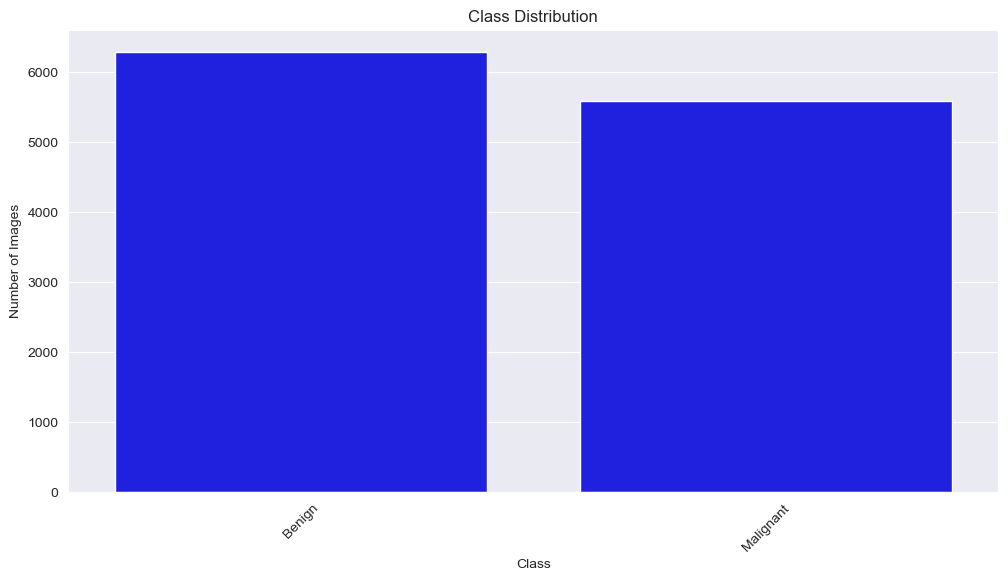

Percentage of images per class:
Class
Benign       52.942167
Malignant    47.057833
Name: proportion, dtype: float64
Counter({0: 6289, 1: 5590})


In [4]:
class_indices = [s[1] for s in dataset.samples]

df = pd.DataFrame({'Class': [class_names[idx] for idx in class_indices]})

plt.figure(figsize=(12, 6))
sns.countplot(x='Class', data=df, color='blue')
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

class_counts = df['Class'].value_counts(normalize=True) * 100
print("Percentage of images per class:")
print(class_counts)
class_counts = Counter([label for _, label in dataset])
print(class_counts)

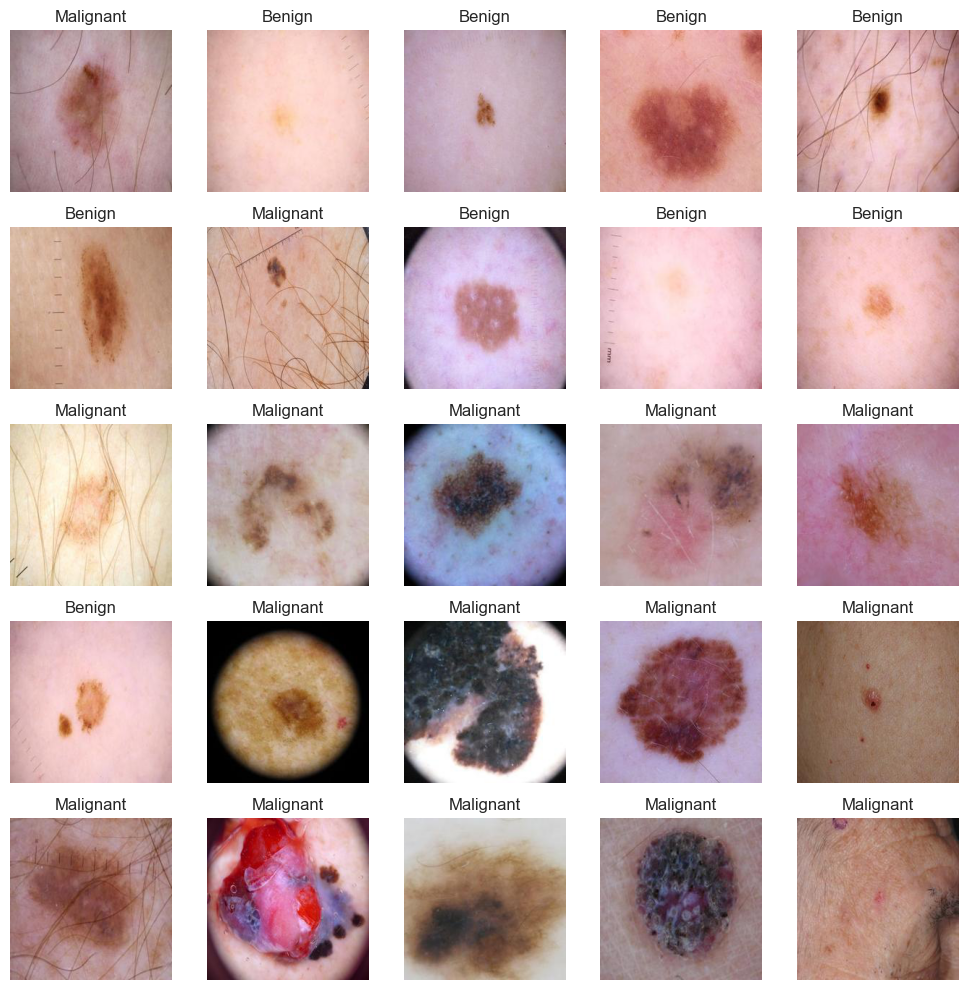

In [5]:
def show_samples(dataset, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(dataset), num_images, replace=False)
    for i, idx in enumerate(indices):
        img_path, label = dataset.samples[idx]
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(dataset, class_names)

Image Size Statistics:
         Width   Height  Aspect_Ratio
count  11879.0  11879.0       11879.0
mean     224.0    224.0           1.0
std        0.0      0.0           0.0
min      224.0    224.0           1.0
25%      224.0    224.0           1.0
50%      224.0    224.0           1.0
75%      224.0    224.0           1.0
max      224.0    224.0           1.0
Number of images not of size 300x300: 11879


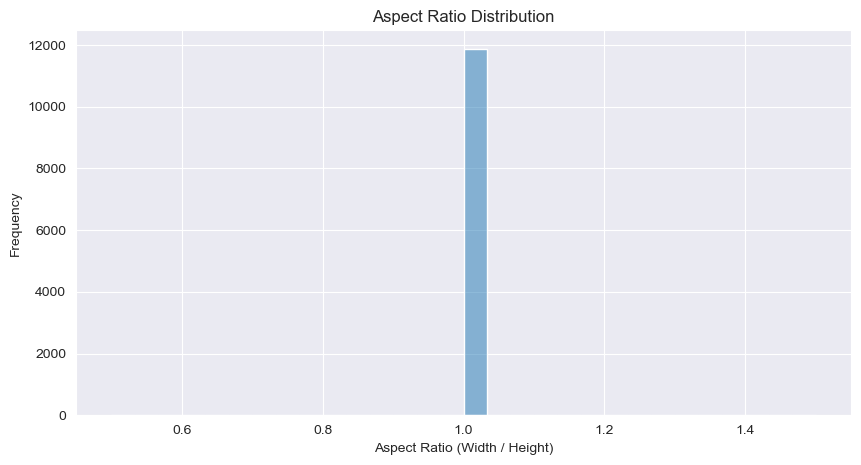

In [6]:
image_sizes = []
for img_path, _ in dataset.samples:
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
df_sizes['Aspect_Ratio'] = df_sizes['Width'] / df_sizes['Height']

print("Image Size Statistics:")
print(df_sizes.describe())

desired_width = 300
desired_height = 300

incorrect_size = df_sizes[
    (df_sizes['Width'] != desired_width) | (df_sizes['Height'] != desired_height)
]

print(f"Number of images not of size {desired_width}x{desired_height}: {len(incorrect_size)}")

plt.figure(figsize=(10, 5))
sns.histplot(df_sizes['Aspect_Ratio'], bins=30, kde=True)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

In [8]:
def is_grayscale(img_path):
    with Image.open(img_path) as img:
        img_np = np.array(img)
        if len(img_np.shape) == 2:
            return True
        elif len(img_np.shape) == 3:
            if np.all(img_np[:, :, 0] == img_np[:, :, 1]) and np.all(img_np[:, :, 1] == img_np[:, :, 2]):
                return True
        return False

grayscale_count = 0
for img_path, _ in dataset.samples:
    if is_grayscale(img_path):
        grayscale_count += 1

print(f'Grayscale images: {grayscale_count}')
print(f'Percentage of grayscale images: {(grayscale_count / num_images) * 100:.2f}%')


Grayscale images: 0
Percentage of grayscale images: 0.00%


Noise Levels Statistics:
              Noise
count  11879.000000
mean     159.743847
std      341.870974
min        3.738650
25%       30.026456
50%       58.676816
75%      134.881134
max     6741.003714


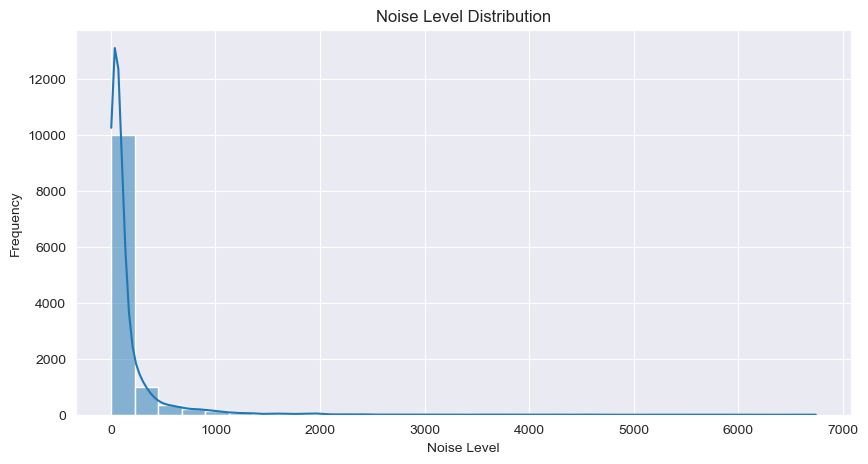

In [11]:
def estimate_noise(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return 0
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    return noise

noise_levels = []
for img_path, _ in dataset.samples:
    noise = estimate_noise(img_path)
    noise_levels.append(noise)

df_noise = pd.DataFrame({'Noise': noise_levels})
print("Noise Levels Statistics:")
print(df_noise.describe())

plt.figure(figsize=(10, 5))
sns.histplot(df_noise['Noise'], bins=30, kde=True)
plt.title('Noise Level Distribution')
plt.xlabel('Noise Level')
plt.ylabel('Frequency')
plt.show()

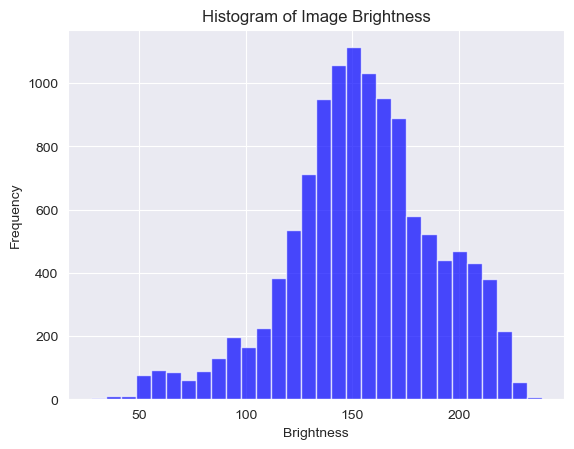

In [12]:
brightness = [np.array(image).mean() for image, _ in dataset]
plt.hist(brightness, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Image Brightness')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()

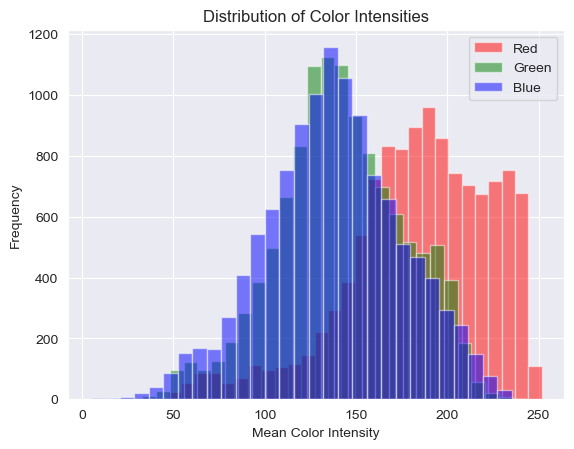

In [13]:
r_values, g_values, b_values = [], [], []

for image, _ in dataset:
    np_image = np.array(image)
    r_values.append(np_image[:, :, 0].mean())
    g_values.append(np_image[:, :, 1].mean())
    b_values.append(np_image[:, :, 2].mean())

plt.hist(r_values, bins=30, alpha=0.5, label='Red', color='r')
plt.hist(g_values, bins=30, alpha=0.5, label='Green', color='g')
plt.hist(b_values, bins=30, alpha=0.5, label='Blue', color='b')
plt.xlabel('Mean Color Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Color Intensities')
plt.legend()
plt.show()